In [5]:
import torch
import numpy as np
import os
import sys 
import importlib

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)
# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
from evaluation.networks import DrawNeuralNetwork


# Local imports
import toy_models.train
import toy_models.polytope

# Reload modules for interactive sessions

# Specific imports from local modules
from toy_models.polytope import ReluNetwork, GeneratePolytopeData
from toy_models.train import TrainModel

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [26]:

n_inputs = 3
n_input_choices = 3
n_polytopes = n_input_choices**n_inputs
n_hidden_neurons = 4
n_hidden_layers = 4
n_samples = 1000
n_epochs = 1000

learning_rate = .01


# Load TMS model
polytope_model  = ReluNetwork(n_inputs, n_polytopes, n_hidden_neurons,n_hidden_layers).to(device)

polytope_model.load_state_dict(torch.load(f"{parent_dir}/models/polytope.pth", weights_only=True))



<All keys matched successfully>

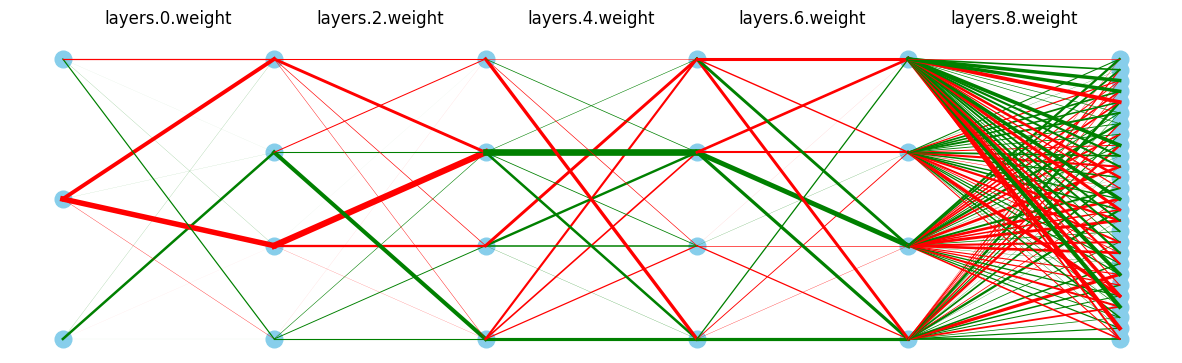

In [12]:
DrawNeuralNetwork({name:param.transpose(0,1) for name,param in polytope_model.named_parameters() if 'weight' in name})

In [17]:
print("generating data")


eigen_X, _, _ = GeneratePolytopeData(n_inputs, n_polytopes, 100, n_input_choices)

eval_X, _, _ = GeneratePolytopeData(n_inputs, n_polytopes, 100, n_input_choices)

generating data


In [18]:
# Remember to login to wandb!
!wandb login ${WANDB_API}

import sys
import os 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import wandb


# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.examples'))
importlib.reload(importlib.import_module('evaluation.networks'))

importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.examples import TopActivatingSamples 
from evaluation.networks import DrawNeuralNetwork

from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams, RetrieveWandBArtifact

device = 'cuda'

wandb: Currently logged in as: brianna-chrisman (brianna-chrisman-2024). Use `wandb login --relogin` to force relogin


In [22]:
def model0(y):
    return torch.ones_like(y).softmax(dim=-1)

hora_features = 9
hora_rank = 1

#DeleteParams(polytope_model, [name for name, param in polytope_model.#named_parameters() if 'bias' in name])

eigen_X
eigenmodel = EigenHora(
    polytope_model, model0, loss.KLDivergenceLoss(), hora_features, hora_rank, device=device).to(device)
dataloader = TransformDataLoader(
    eigen_X.to(device), batch_size=16, transform_fn=eigenmodel.compute_jacobian)

eval_dataloader = TransformDataLoader(eval_X.to(device), batch_size=16, transform_fn=eigenmodel.compute_jacobian)

project_name = 'eigenestimation'
run_name = 'polytopes'

Train(eigenmodel, dataloader, lr=.001, n_epochs=500, L0_penalty=.01, device=device, project_name=project_name, run_name=run_name,
      eval_fns={TopActivatingSamples:[10, None, True]}, eval_dataloader=eval_dataloader) 


RuntimeError: einsum(): subscript c has size 4 for operand 1 which does not broadcast with previously seen size 16